# Makemore Part 3

> Activations and Gradients, Batchnorm

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
words = open('../names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
''.join(words[:2]), set(''.join(words[:2]))

('emmaolivia', {'a', 'e', 'i', 'l', 'm', 'o', 'v'})

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #add special dot character to the vocabulary
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 28.4938


The initial loss is way too high because the net is assigning a large probability to an incorrect prediction (this means that the correct next character has a teeny probability assigned to it and we end up getting hit with a high loss). Recall that log of values close to 0 goes to minus infinity. 

In [ ]:
# initial logits all over the place. Resulting in misplaced high confidence
# on an incorrect prediction
logits[0]

tensor([ -4.4603,  32.3673, -11.6979,   5.5694,  20.0896,  -6.2950,  -8.1618,
         -2.7348,  -0.2872,  11.4558,  17.1132,  -6.7761,   6.7740, -24.2789,
        -11.2737,   6.2158,  -2.4765,  -9.5571, -29.2264,  -6.8632,  24.5954,
          8.4046,  15.8890, -10.7344, -19.6579,   7.8470,  11.4100],
       grad_fn=<SelectBackward0>)

In [ ]:
# However what we want the net to do is to output uniform probabilities 
# for the next character and hence obtain the following loss:
-torch.tensor(1/27.).log()

tensor(3.2958)

In [ ]:
# infinite loss for this contrived 4-d example
logits = torch.tensor([0.,5000.,0.,0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([   0., 5000.,    0.,    0.]), tensor([0., 1., 0., 0.]), tensor(inf))

In [ ]:
# rather we want at the initial step for the net
# to output a uniform probability for the next
# character
# Though we only want them to be roughly the same
# and not exactly the same for the purposes of 
# symmetry breaking.
logits = torch.tensor([0.,0.,0.,0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So in the output layer let's set:

* the biases to zero 
* multiply the weights by a small number

so they cannot contribute to the initial predictions being all over the place.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01
b2 = torch.randn(vocab_size,                      generator=g)*0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3277
  10000/ 200000: 2.2796
  20000/ 200000: 2.4154
  30000/ 200000: 2.6209
  40000/ 200000: 1.9621
  50000/ 200000: 2.3349
  60000/ 200000: 2.4446
  70000/ 200000: 2.1641
  80000/ 200000: 2.3063
  90000/ 200000: 2.2793
 100000/ 200000: 1.8783
 110000/ 200000: 2.1199
 120000/ 200000: 1.9415
 130000/ 200000: 2.2646
 140000/ 200000: 2.2047
 150000/ 200000: 2.1859
 160000/ 200000: 1.8602
 170000/ 200000: 1.7062
 180000/ 200000: 1.9129
 190000/ 200000: 1.9113


[<matplotlib.lines.Line2D>]

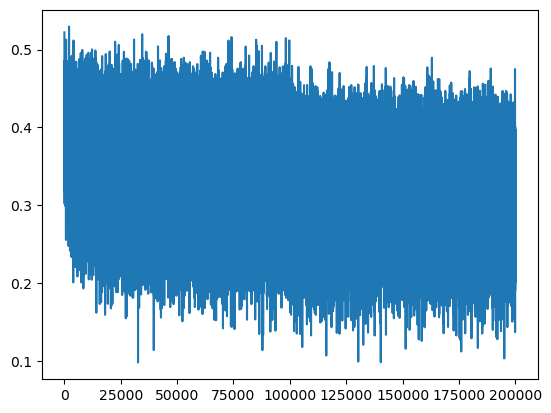

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.218263864517212
val 2.270463228225708


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view((1,-1)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

carma.
xath.
levian.
mili.
tatyanna.
sane.
azhael.
amerric.
areei.
arlosiah.
maiivia.
leigh.
ham.
foli.
quinn.
sulisean.
adis.
waveron.
jarinittine.
cirrat.


#|hide

Stop at 13m01s / 1h55m57s